### Hipótese
ZCTAs com maior concentração de idosos demandam mais exames diagnósticos.

---

In [1]:
# Importando bibliotecas
import warnings
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Carregando os data sets relacionados
transactional_data = pd.read_csv('../../../data/processed/transactional_data_clean.csv')
demographic_data = pd.read_csv('../../../data/processed/demographic_data_clean.csv')

In [3]:
# 1. Pré-processamento dos dados
# Convertendo campos de data para datetime
transactional_data['dateofbirth'] = pd.to_datetime(transactional_data['dateofbirth'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
transactional_data['dateofservice'] = pd.to_datetime(transactional_data['dateofservice'], format='%Y-%m-%d', errors='coerce')

# Calculando a idade do paciente no momento do exame
transactional_data['age_at_service'] = (transactional_data['dateofservice'] - transactional_data['dateofbirth']).dt.days / 365.25

In [4]:
# Criando faixas etárias para análise
age_bins = [0, 5, 9, 14, 19, 24, 34, 44, 54, 59, 64, 74, 84, 120]
age_labels = ['0-5', '6-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-54', '55-59', '60-64', '65-74', '75-84', '85+']
transactional_data['age_group'] = pd.cut(transactional_data['age_at_service'], bins=age_bins, labels=age_labels)

transactional_data.head()

,patient_id,gender,dateofbirth,dateofservice,service_id,lab_id,cod_item,testing_cost,age_at_service,age_group
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42.433949,35-44
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42.433949,35-44
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42.433949,35-44
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42.433949,35-44
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42.433949,35-44


In [5]:
# 2. Análise do volume de exames por faixa etária
exams_by_age = transactional_data.groupby('age_group').size().reset_index(name='exam_count')
exams_by_age['percentage'] = (exams_by_age['exam_count'] / exams_by_age['exam_count'].sum()) * 100

# Agrupando população por faixas etárias criadas
demo_age_groups = demographic_data['age_group'].unique()

# Mapeamento entre os grupos demográficos e as faixas etárias
demographic_mapping = {
    '< 5 Years': '0-5',
    '5 - 9 Years': '6-9',
    '10 - 14 Years': '10-14',
    '15 - 19 Years': '15-19',
    '20 - 24 Years': '20-24',
    '25 - 34 Years': '25-34',
    '35 - 44 Years': '35-44',
    '45 - 54 Years': '45-54',
    '55 - 59 Years': '55-59',
    '60 - 64 Years': '60-64',
    '65 - 74 Years': '65-74',
    '75 - 84 Years': '75-84',
    '85 Years >=': '85+'
}

In [6]:
# Aplicando o mapeamento
demographic_data['mapped_age_group'] = demographic_data['age_group'].map(demographic_mapping)

demographic_data.head()

,id,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,age_group,group_population,mapped_age_group
0,8600000US35004,35004,12045,94.1,35.5,< 5 Years,805,0-5
1,8600000US35005,35005,7344,86.1,44.0,< 5 Years,504,0-5
2,8600000US35006,35006,2883,108.2,47.2,< 5 Years,96,0-5
3,8600000US35007,35007,26332,95.0,37.7,< 5 Years,1936,0-5
4,8600000US35010,35010,20613,90.5,42.6,< 5 Years,1306,0-5


In [7]:
# Agrupando a população por nossas faixas etárias
population_by_age = demographic_data.groupby('mapped_age_group')['group_population'].sum().reset_index()
population_by_age['percentage'] = (population_by_age['group_population'] / population_by_age['group_population'].sum()) * 100

population_by_age.head()

,mapped_age_group,group_population,percentage
0,0-5,19666377,6.090934
1,10-14,20891708,6.470435
2,15-19,21042089,6.517010
3,20-24,21707295,6.723033
4,25-34,44559390,13.800626


In [8]:
# Juntando os dados para comparação
comparison_df = pd.merge(exams_by_age, population_by_age, left_on='age_group', right_on='mapped_age_group', how='left')
comparison_df.rename(columns={'percentage_x': 'exams_percentage', 'percentage_y': 'population_percentage'}, inplace=True)

# Calculando a taxa de exames relativa à população
comparison_df['exams_per_capita'] = comparison_df['exam_count'] / comparison_df['group_population']
comparison_df['demand_index'] = comparison_df['exams_percentage'] / comparison_df['population_percentage']

comparison_df.head()

,age_group,exam_count,exams_percentage,mapped_age_group,group_population,population_percentage,exams_per_capita,demand_index
0,0-5,55856,2.708172,0-5,19666377,6.090934,0.002840,0.444623
1,6-9,40087,1.943614,6-9,20098238,6.224687,0.001995,0.312243
2,10-14,45347,2.198645,10-14,20891708,6.470435,0.002171,0.339799
3,15-19,58294,2.826378,15-19,21042089,6.517010,0.002770,0.433693
4,20-24,105553,5.117726,20-24,21707295,6.723033,0.004863,0.761223


In [10]:
# 3. Análise do custo médio dos exames por faixa etária
cost_by_age = transactional_data.groupby('age_group')['testing_cost'].agg(['mean', 'median', 'sum']).reset_index()
cost_by_age.columns = ['age_group', 'mean_cost', 'median_cost', 'total_cost']
cost_by_age['cost_percentage'] = (cost_by_age['total_cost'] / cost_by_age['total_cost'].sum()) * 100

cost_by_age.head()

,age_group,mean_cost,median_cost,total_cost,cost_percentage
0,0-5,105.144508,31.0,5872951.62,5.576292
1,6-9,63.416976,25.0,2542196.32,2.413783
2,10-14,60.559035,26.0,2746170.54,2.607454
3,15-19,41.988689,18.0,2447688.64,2.324049
4,20-24,46.807080,26.0,4940627.75,4.691063


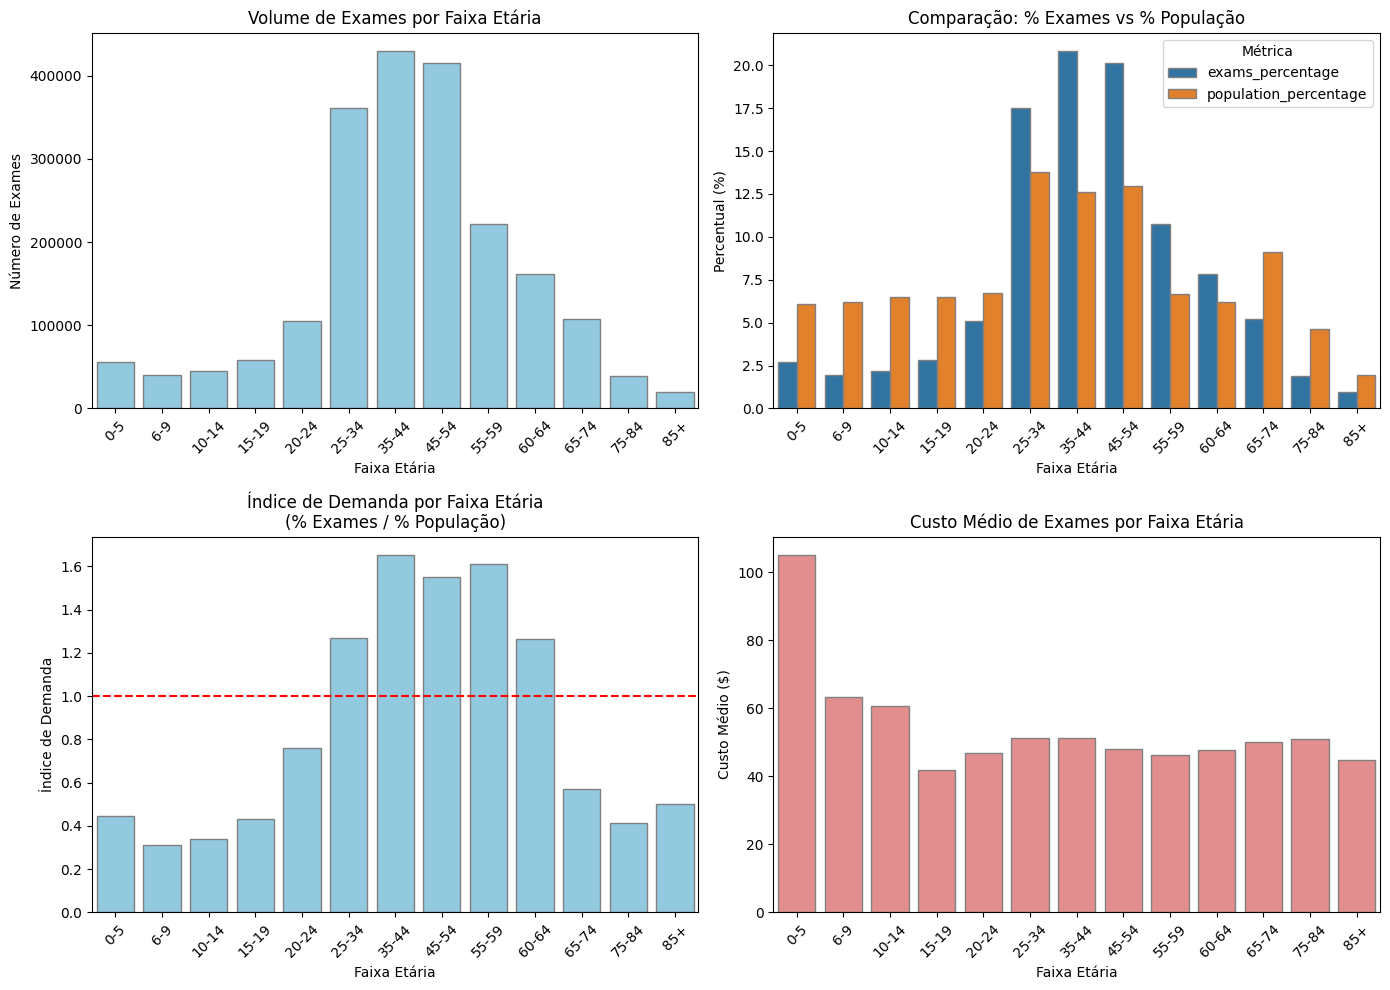

In [11]:
# 4. Visualização dos Resultados
plt.figure(figsize=(14, 10))

# Volume de exames por faixa etária
plt.subplot(2, 2, 1)
sns.barplot(x='age_group', y='exam_count', data=exams_by_age, color='skyblue', edgecolor='gray')
plt.title('Volume de Exames por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)

# Comparação entre percentual de exames e percentual da população
plt.subplot(2, 2, 2)
comparison_df_melted = pd.melt(comparison_df, id_vars=['age_group'],
                              value_vars=['exams_percentage', 'population_percentage'],
                              var_name='Metric', value_name='Percentage')
sns.barplot(x='age_group', y='Percentage', hue='Metric', data=comparison_df_melted, edgecolor='gray')
plt.title('Comparação: % Exames vs % População')
plt.xlabel('Faixa Etária')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Métrica')

# Índice de demanda (exames per capita normalizado)
plt.subplot(2, 2, 3)
sns.barplot(x='age_group', y='demand_index', data=comparison_df, color='skyblue', edgecolor='gray')
plt.title('Índice de Demanda por Faixa Etária\n(% Exames / % População)')
plt.xlabel('Faixa Etária')
plt.ylabel('Índice de Demanda')
plt.xticks(rotation=45)
plt.axhline(y=1, color='r', linestyle='--')  # Linha de referência onde % exames = % população

# Custo médio por faixa etária
plt.subplot(2, 2, 4)
sns.barplot(x='age_group', y='mean_cost', data=cost_by_age, color='lightcoral', edgecolor='gray')
plt.title('Custo Médio de Exames por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Custo Médio ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# 5. Análise estatística para verificar se há diferença significativa entre as faixas etárias
print("\n===== Testes Estatísticos =====")

# ANOVA para testar se há diferença significativa no número de exames por paciente entre faixas etárias
exams_per_patient = transactional_data.groupby(['patient_id', 'age_group']).size().reset_index(name='exam_count')

# Lista para armazenar os dados de cada grupo para ANOVA
age_groups_data = [group['exam_count'].values for name, group in exams_per_patient.groupby('age_group')]

# Realizando o teste ANOVA
f_stat, p_value = stats.f_oneway(*age_groups_data)
print(f"ANOVA - Diferença no número de exames por paciente entre faixas etárias:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.10f}")
print(f"{'Diferença estatisticamente significativa' if p_value < 0.05 else 'Não há diferença estatisticamente significativa'}")


===== Testes Estatísticos =====
ANOVA - Diferença no número de exames por paciente entre faixas etárias:
F-statistic: 9540.0360, p-value: 0.0000000000
Diferença estatisticamente significativa


In [14]:
# 6. Resumo dos resultados
print("\n===== Resumo da Análise =====")
print("\nVolume de exames por faixa etária:")
print(exams_by_age.to_string(index=False))

print("\nComparação entre % de exames e % da população:")
print(comparison_df[['age_group', 'exams_percentage', 'population_percentage', 'demand_index']].to_string(index=False))

print("\nCusto médio e total por faixa etária:")
print(cost_by_age[['age_group', 'mean_cost', 'total_cost', 'cost_percentage']].to_string(index=False))


===== Resumo da Análise =====

Volume de exames por faixa etária:
age_group  exam_count  percentage
      0-5       55856    2.708172
      6-9       40087    1.943614
    10-14       45347    2.198645
    15-19       58294    2.826378
    20-24      105553    5.117726
    25-34      361711   17.537520
    35-44      430043   20.850590
    45-54      415162   20.129086
    55-59      221901   10.758847
    60-64      161657    7.837923
    65-74      107372    5.205920
    75-84       39367    1.908705
      85+       20148    0.976874

Comparação entre % de exames e % da população:
age_group  exams_percentage  population_percentage  demand_index
      0-5          2.708172               6.090934      0.444623
      6-9          1.943614               6.224687      0.312243
    10-14          2.198645               6.470435      0.339799
    15-19          2.826378               6.517010      0.433693
    20-24          5.117726               6.723033      0.761223
    25-34         1

---

### Conclusão

A análise da hipótese de que determinadas faixas etárias, como os idosos, demandariam mais exames diagnósticos revelou resultados estatisticamente significativos (ANOVA F=9540.04, p<0.0000000000), comprovando diferenças marcantes no comportamento de utilização dos serviços diagnósticos conforme a idade, porém não como os idosos especificados pela hipótese.

- **Volume Absoluto de Exames:**  
  As faixas etárias de 35-44 e 45-54 apresentam os maiores volumes de exames, contribuindo com 20,85% e 20,13% do total, respectivamente, seguidas pela faixa 25-34 (17,54%) e 55-59 (10,76%). Em contrapartida, os grupos considerados idosos (65-74: 5,21%, 75-84: 1,91% e 85+: 0,98%) têm uma representatividade menor no volume total de exames, o que contradiz parcialmente a hipótese inicial de que os idosos demandariam mais exames.

- **Índice de Demanda em Relação à População:**  
  Ao comparar o percentual de exames com o percentual da população, observa-se que as faixas 25-34 (índice=1.27), 35-44 (índice=1.65), 45-54 (índice=1.55) e 55-59 (índice=1.61) demandam exames em proporção superior à sua participação populacional. Já os grupos de crianças (0-5, 6-9, 10-14 e 15-19) e idosos (65-74, 75-84 e 85+) apresentam índices bem abaixo de 1.

- **Análise de Custos:**  
  Embora a faixa etária de 0-5 anos represente apenas 2,71% do total de exames, ela destaca-se pelo custo médio elevado ($105,14), correspondendo a 5,58% do custo total, o que pode indicar a complexidade ou especialização dos exames nesta faixa. Por outro lado, as faixas de maior volume (25-34, 35-44 e 45-54) apresentam custos médios próximos (entre $47,89 e $51,31) e concentram a maior parte dos gastos totais (17,61%, 20,95% e 18,88%, respectivamente).

Esses resultados sugerem que a maior demanda por exames não está concentrada apenas nos idosos, mas principalmente em adultos de meia-idade, especialmente nas faixas de 25 a 59 anos e o maior custo por exama está no grupo de 0 a 5 anos. Assim, para o plano de expansão, recomenda-se priorizar regiões com maior concentração desses grupos e para priorizar esses grupos será utilizado o critério de menor concetração do grupo de 0 a 5 anos.